<a href="https://colab.research.google.com/github/GiacomoT23/Euro-MachineTranslation-SFT-and-RL/blob/main/de_en_qwen_preprocessing_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing numpy for fasttext

In [ ]:
!pip -q install "numpy<2.0.0" #needed for fasttext (language detection)
!pip -q install fasttext==0.9.2 huggingface_hub
import os

print("✅ Installation completed. Restarting runtime")
os.kill(os.getpid(), 9)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 74.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np, fasttext
print("NumPy:", np.__version__) #check

NumPy: 1.26.4


# Dataset download

In [ ]:
!pip -q install "datasets>=3.4.1,<4.0.0"
from datasets import load_dataset

YEAR = "wmt14"
PAIR = "de-en"
SRC, TGT = PAIR.split("-")

ds = load_dataset(YEAR, PAIR)

print({split: len(ds[split]) for split in ds.keys()})
ds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.9 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

de-en/train-00000-of-00003.parquet:   0%|          | 0.00/280M [00:00<?, ?B/s]

de-en/train-00001-of-00003.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

de-en/train-00002-of-00003.parquet:   0%|          | 0.00/273M [00:00<?, ?B/s]

de-en/validation-00000-of-00001.parquet:   0%|          | 0.00/474k [00:00<?, ?B/s]

de-en/test-00000-of-00001.parquet:   0%|          | 0.00/509k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4508785 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3003 [00:00<?, ? examples/s]

{'train': 4508785, 'validation': 3000, 'test': 3003}


DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 4508785
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 3003
    })
})

# Load model tokenizer
It will be used to obtain the length in tokens of the sentences in the dataset

In [ ]:
%%capture
!pip install --no-input "transformers==4.55.4" "tiktoken>=0.6.0"

from transformers import AutoTokenizer

# === Config ===
TOKENIZER_ID = "Qwen/Qwen2.5-3B"

# === Tokenizer only ===
tokenizer = AutoTokenizer.from_pretrained(
    TOKENIZER_ID,
    use_fast=True,
    trust_remote_code=True,
)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

tokenizer.padding_side = "right"

print(f"Tokenizer ready: {TOKENIZER_ID} | vocab={tokenizer.vocab_size} | pad={tokenizer.pad_token!r}")


# Sampling 150k from training set

In [ ]:
import random
from datasets import DatasetDict

# --- Config ---
SAMPLE_SIZE = 150_000
SEED = 3407

n_train = len(ds["train"])
k = min(SAMPLE_SIZE, n_train)
random.seed(SEED)
indices = random.sample(range(n_train), k=k)

ds_sampled = DatasetDict({
    "train": ds["train"].select(indices),
    "validation": ds["validation"],
    "test": ds["test"],
})

print({split: len(ds_sampled[split]) for split in ds_sampled.keys()})
ds_sampled


{'train': 150000, 'validation': 3000, 'test': 3003}


DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 150000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 3003
    })
})

# Save to drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os, shutil
from datasets import load_from_disk

# == Config ==
BASE_DIR  = "/content/drive/MyDrive/mt_datasets"
DATA_NAME = f"{YEAR}_{PAIR}_sample{len(ds_sampled['train'])}_qwen"
SAVE_DIR  = os.path.join(BASE_DIR, DATA_NAME)

OVERWRITE = False

os.makedirs(BASE_DIR, exist_ok=True)

# Overwriting management
if os.path.isdir(SAVE_DIR):
    if OVERWRITE:
        shutil.rmtree(SAVE_DIR)
    else:
        raise FileExistsError(f"Already existing folder: {SAVE_DIR}")

# Saving
ds_sampled.save_to_disk(SAVE_DIR)
print(f"✅ Dataset saved in: {SAVE_DIR}")

Mounted at /content/drive


Saving the dataset (0/1 shards):   0%|          | 0/150000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3003 [00:00<?, ? examples/s]

✅ Dataset salvato in: /content/drive/MyDrive/mt_datasets/wmt14_de-en_sample150000_qwen


# Loading from drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
from datasets import load_from_disk

# === Config ===
DATA_NAME = "wmt14_de-en_sample150000_qwen"

BASE_DIR = "/content/drive/MyDrive/mt_datasets"
SAVE_DIR = os.path.join(BASE_DIR, DATA_NAME)

if not os.path.isdir(SAVE_DIR):
    raise FileNotFoundError(f"Folder not found: {SAVE_DIR}")

print(f"Loading dataset from: {SAVE_DIR}")
ds_sampled = load_from_disk(SAVE_DIR)

print({split: len(ds_sampled[split]) for split in ds_sampled.keys()})
ds_sampled

Mounted at /content/drive
Loading dataset from: /content/drive/MyDrive/mt_datasets/wmt14_de-en_sample150000_qwen
{'train': 150000, 'validation': 3000, 'test': 3003}


DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 150000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 3003
    })
})

# Dataset exploration: length distribution (in tokens)
Analyzing length distribution in the 3 splits

[train] Percentiles
  SRC     : {'p50': 36, 'p90': 74, 'p95': 89, 'p99': 126}
  TGT     : {'p50': 25, 'p90': 50, 'p95': 60, 'p99': 88}
  SRC+TGT : {'p50': 62, 'p90': 121, 'p95': 145, 'p99': 205}
[validation] Percentiles
  SRC     : {'p50': 30, 'p90': 62, 'p95': 75, 'p99': 101}
  TGT     : {'p50': 21, 'p90': 42, 'p95': 50, 'p99': 69}
  SRC+TGT : {'p50': 51, 'p90': 104, 'p95': 125, 'p99': 169}
[test] Percentiles
  SRC     : {'p50': 33, 'p90': 63, 'p95': 73, 'p99': 91}
  TGT     : {'p50': 23, 'p90': 43, 'p95': 49, 'p99': 63}
  SRC+TGT : {'p50': 56, 'p90': 105, 'p95': 120, 'p99': 151}


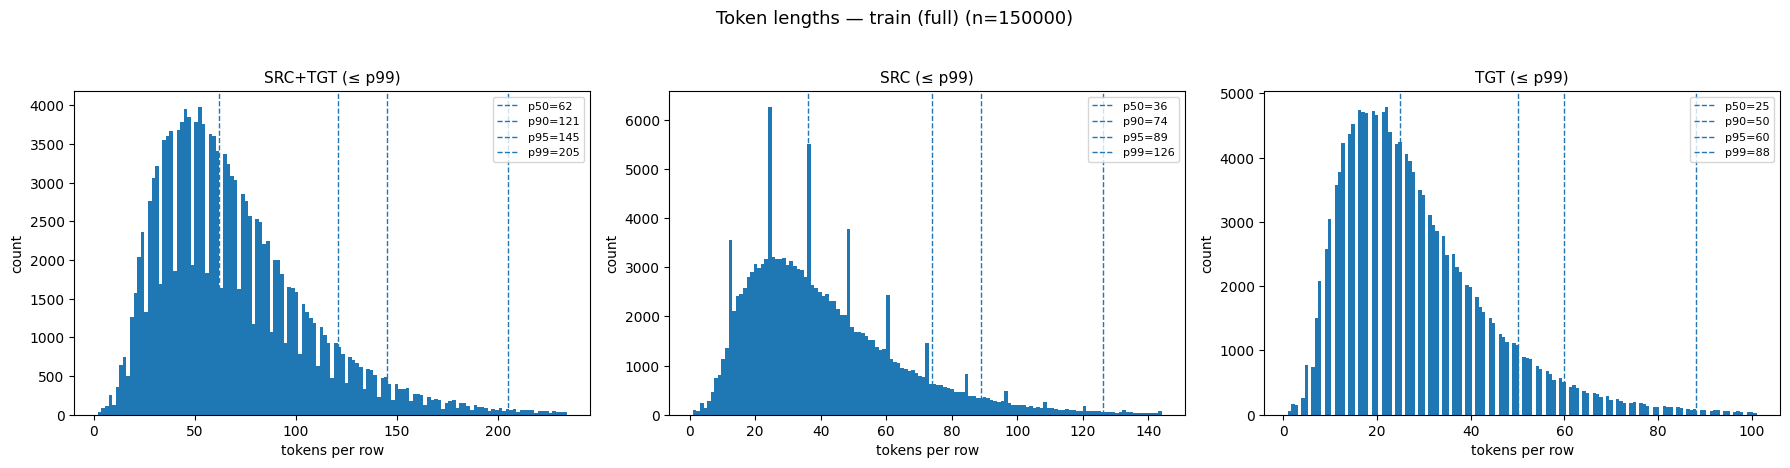

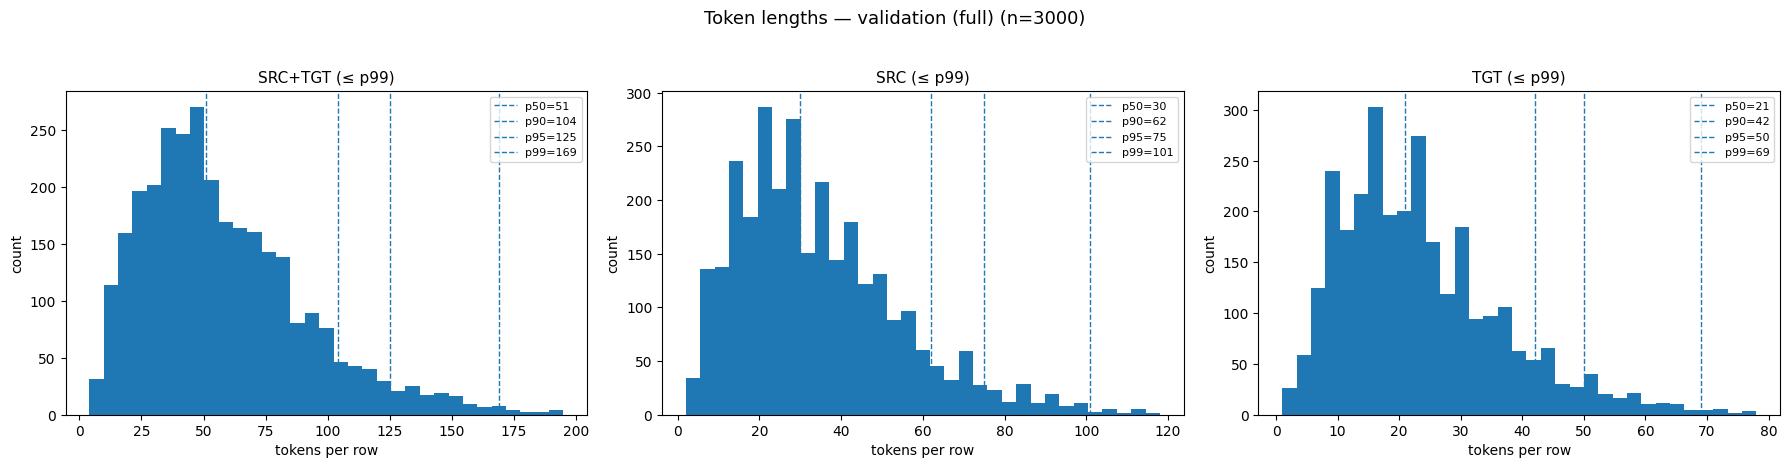

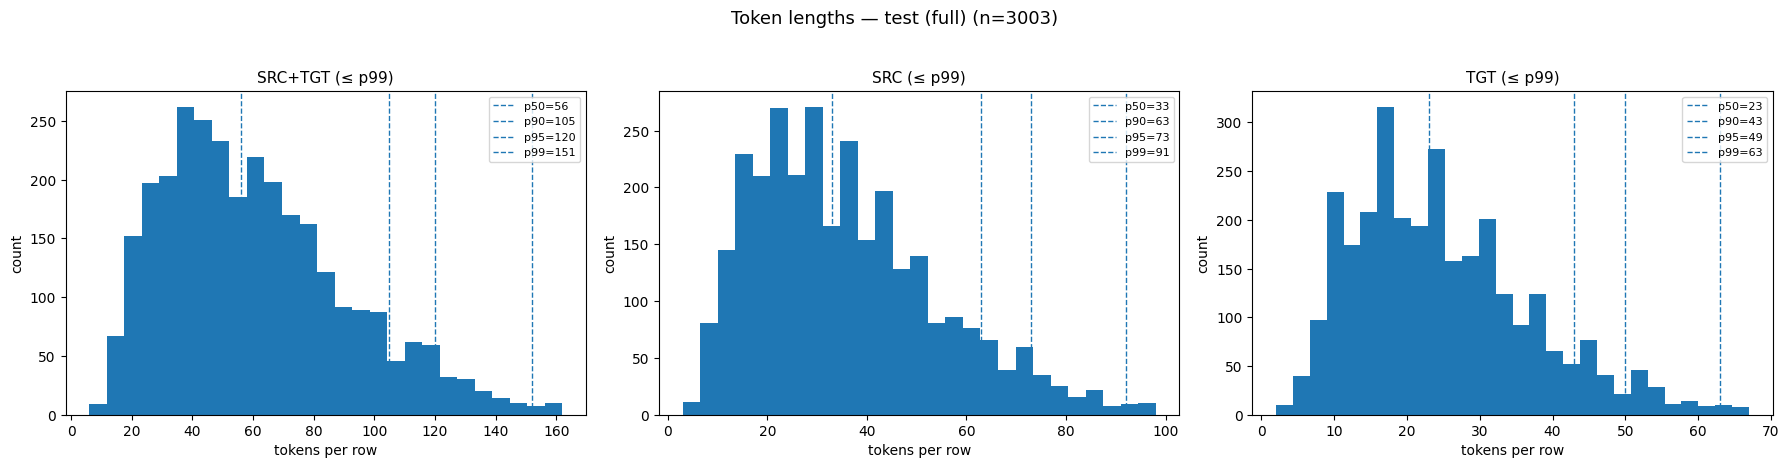

In [ ]:
# === Token length distribution on FULL ds_sampled ===
import numpy as np
import matplotlib.pyplot as plt
from datasets import DatasetDict

SRC, TGT = "de", "en"

def percentili(a):
    a = np.asarray(a)
    return {k:int(v) for k,v in zip(["p50","p90","p95","p99"], np.percentile(a, [50,90,95,99]))}

def add_lengths(batch):
    src = [x[SRC] for x in batch["translation"]]
    tgt = [x[TGT] for x in batch["translation"]]
    enc_s = tokenizer(src, add_special_tokens=False, return_length=True,
                      return_attention_mask=False, return_token_type_ids=False)
    enc_t = tokenizer(tgt, add_special_tokens=False, return_length=True,
                      return_attention_mask=False, return_token_type_ids=False)
    len_src = enc_s["length"]; len_tgt = enc_t["length"]
    len_sum = (np.array(len_src) + np.array(len_tgt)).tolist()
    return {"len_src": len_src, "len_tgt": len_tgt, "len_sum": len_sum}

def ensure_lengths_for_split(dset, split_name, num_proc=2, batch_size=4096):
    need = any(c not in dset.column_names for c in ("len_src","len_tgt","len_sum"))
    if need:
        dset = dset.map(
            add_lengths, batched=True, batch_size=batch_size, num_proc=num_proc,
            desc=f"[{split_name}] add token lengths"
        )
    ls = np.array(dset["len_src"], dtype=np.int32)
    lt = np.array(dset["len_tgt"], dtype=np.int32)
    lm = np.array(dset["len_sum"], dtype=np.int32)
    print(f"[{split_name}] Percentiles")
    print("  SRC     :", percentili(ls))
    print("  TGT     :", percentili(lt))
    print("  SRC+TGT :", percentili(lm))
    return ls, lt, lm, dset

splits = [s for s in ("train","validation","test") if s in ds_sampled]
lens = {}
updated = {}
for sp in splits:
    ls, lt, lm, d2 = ensure_lengths_for_split(ds_sampled[sp], sp)
    lens[sp] = (ls, lt, lm)
    updated[sp] = d2

ds_sampled = DatasetDict(updated)

# ---- Plot config ----
QCLIP = 0.995
BINS_METHOD = "fd"
MIN_BINS = 20

def edges_adaptive(arr_clip):
    if arr_clip.size == 0:
        return np.array([0, 1])
    edges = np.histogram_bin_edges(arr_clip, bins=BINS_METHOD)
    if (len(edges) - 1) < MIN_BINS:
        edges = np.linspace(arr_clip.min(), arr_clip.max(), MIN_BINS + 1)
    return edges

def plot_one(ax, arr, title):
    arr = np.asarray(arr)
    if arr.size == 0:
        ax.set_title(f"{title} (vuoto)", fontsize=11); ax.axis("off"); return
    hi = np.quantile(arr, QCLIP)
    arr_clip = arr[arr <= hi]
    edges = edges_adaptive(arr_clip)
    ax.hist(arr_clip, bins=edges)
    for p in (50, 90, 95, 99):
        v = np.percentile(arr, p)
        if v <= hi:
            ax.axvline(v, linestyle="--", linewidth=1, label=f"p{p}={int(v)}")
    ax.set_title(f"{title} (≤ p{int(QCLIP*100)})", fontsize=11)
    ax.set_xlabel("tokens per row"); ax.set_ylabel("count")
    ax.legend(loc="upper right", fontsize=8)

def plot_row(split_name, len_src, len_tgt, len_sum, note=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 4.5))
    title = f"Token lengths — {split_name}" + (f" ({note})" if note else "")
    fig.suptitle(title, fontsize=13, y=1.03)
    plot_one(axs[0], len_sum, "SRC+TGT")
    plot_one(axs[1], len_src, "SRC")
    plot_one(axs[2], len_tgt, "TGT")
    plt.tight_layout(); plt.show()

for sp in splits:
    ls, lt, lm = lens[sp]
    plot_row(f"{sp} (full)", ls, lt, lm, note=f"n={len(lm)}")


# Dataset exploration: distributions of likelihoods to be German and English
Use of the model fasttext to analyze the likelhoods of the sentences to be in German/English. Computing the number of couples of sentences having both scores of the src sentence and target sentence over certain thresholds.

model.bin:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Parameter 'function'=<function add_lid_batch at 0x78942c16b7e0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


✔️ fastText loaded: /root/.cache/huggingface/hub/models--facebook--fasttext-language-identification/snapshots/3af127d4124fc58b75666f3594bb5143b9757e78/model.bin
   Using labels: DE=__label__deu_Latn  EN=__label__eng_Latn


[train] add LID_src/LID_tgt:   0%|          | 0/150000 [00:00<?, ? examples/s]

[validation] add LID_src/LID_tgt:   0%|          | 0/3000 [00:00<?, ? examples/s]

[test] add LID_src/LID_tgt:   0%|          | 0/3003 [00:00<?, ? examples/s]

[train] n=150000  LID_src pct={'p50': 1.0, 'p90': 1.0, 'p95': 1.0, 'p99': 1.0}  LID_tgt pct={'p50': 1.0, 'p90': 1.0, 'p95': 1.0, 'p99': 1.0}
  thr  keep
  0.90 0.942
  0.91 0.940
  0.92 0.939
  0.93 0.937
  0.94 0.935
  0.95 0.933
  0.96 0.929
  0.97 0.924
  0.98 0.914
  0.99 0.889
[validation] n=3000  LID_src pct={'p50': 1.0, 'p90': 1.0, 'p95': 1.0, 'p99': 1.0}  LID_tgt pct={'p50': 1.0, 'p90': 1.0, 'p95': 1.0, 'p99': 1.0}
  thr  keep
  0.90 0.977
  0.91 0.975
  0.92 0.974
  0.93 0.973
  0.94 0.972
  0.95 0.969
  0.96 0.966
  0.97 0.960
  0.98 0.952
  0.99 0.930
[test] n=3003  LID_src pct={'p50': 1.0, 'p90': 1.0, 'p95': 1.0, 'p99': 1.0}  LID_tgt pct={'p50': 1.0, 'p90': 1.0, 'p95': 1.0, 'p99': 1.0}
  thr  keep
  0.90 0.986
  0.91 0.986
  0.92 0.983
  0.93 0.982
  0.94 0.979
  0.95 0.976
  0.96 0.971
  0.97 0.968
  0.98 0.960
  0.99 0.941


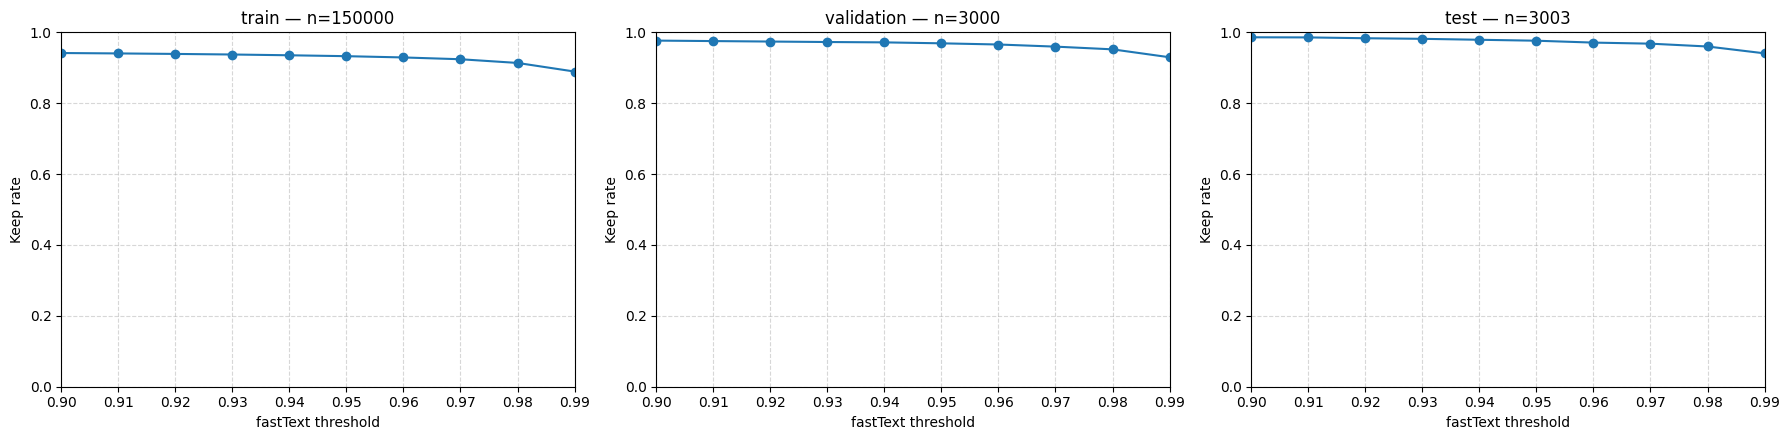

In [ ]:
# === fastText LID: add LID_src / LID_tgt columns + keep-rate curves (thr 0.90..0.99) ===
import os, re, numpy as np, matplotlib.pyplot as plt, fasttext
from datasets import DatasetDict
from huggingface_hub import hf_hub_download
from tqdm.auto import tqdm

# Config
SPLITS = [s for s in ("train","validation","test") if s in ds_sampled]
SRC, TGT = "de", "en"
TOP_K = 5
THRESHOLDS = np.round(np.arange(0.90, 1.00, 0.01), 2)  # 0.90,0.91,...,0.99

# --- Load fastText LID model robustly (use lid.176.bin from HF) ---
try:
    lid_path = hf_hub_download("facebook/fasttext-language-identification", filename="model.bin")
except Exception as e:
    raise RuntimeError(f"Impossibile scaricare lid.176.bin da HF: {e}")
lid = fasttext.load_model(lid_path)

labels_set = set(lid.get_labels())
LAB_DE = "__label__deu_Latn" if "__label__deu_Latn" in labels_set else "__label__de"
LAB_EN = "__label__eng_Latn" if "__label__eng_Latn" in labels_set else "__label__en"
print(f"✔️ fastText loaded: {lid_path}\n   Using labels: DE={LAB_DE}  EN={LAB_EN}")

def clean_text(x: str, max_chars=2000) -> str:
    x = (x or "").replace("\r"," ").replace("\n"," ").strip()
    return re.sub(r"\s+", " ", x)[:max_chars]

def _prob_for_label(txt: str, want_label: str, k: int = TOP_K) -> float:
    labels, probs = lid.predict(clean_text(txt), k=k)
    for l, p in zip(labels, probs):
        if l == want_label:
            return float(p)
    return 0.0

def add_lid_batch(batch):
    srcs = [ex.get(SRC,"") for ex in batch["translation"]]
    tgts = [ex.get(TGT,"") for ex in batch["translation"]]
    p_src = [ _prob_for_label(s, LAB_DE) for s in srcs ]
    p_tgt = [ _prob_for_label(t, LAB_EN) for t in tgts ]
    return {"LID_src": p_src, "LID_tgt": p_tgt}

def ensure_lid_for_split(dset, split_name, num_proc=1, batch_size=1024):
    need = any(c not in dset.column_names for c in ("LID_src", "LID_tgt"))
    if need:
        dset = dset.map(
            add_lid_batch, batched=True, batch_size=batch_size, num_proc=num_proc,
            desc=f"[{split_name}] add LID_src/LID_tgt"
        )
    return dset

# 1) Add columns to dataset
updated = {}
for sp in SPLITS:
    updated[sp] = ensure_lid_for_split(ds_sampled[sp], sp)
ds_sampled = DatasetDict(updated)

# 2) compute keep-rate for thresholds
def pct(a, ps=(50,90,95,99)):
    a = np.asarray(a);
    return {f"p{p}": round(np.percentile(a, p), 3) for p in ps} if len(a) else {}

results = {}
for sp in SPLITS:
    d = ds_sampled[sp]
    src_p = np.asarray(d["LID_src"], dtype=np.float32)
    tgt_p = np.asarray(d["LID_tgt"], dtype=np.float32)
    keep = [ ((src_p >= thr) & (tgt_p >= thr)).mean() for thr in THRESHOLDS ]
    results[sp] = {"thr": THRESHOLDS, "keep": np.array(keep, dtype=np.float32), "n": len(d)}
    print(f"[{sp}] n={len(d)}  LID_src pct={pct(src_p)}  LID_tgt pct={pct(tgt_p)}")
    print("  thr  keep")
    for t, kr in zip(THRESHOLDS, results[sp]["keep"]):
        print(f"  {t:.2f} {kr:5.3f}")

# 3) plot
cols = len(results)
plt.figure(figsize=(6*cols, 4.5))
for j, sp in enumerate(results.keys(), start=1):
    data = results[sp]
    plt.subplot(1, cols, j)
    plt.plot(data["thr"], data["keep"], marker="o")
    plt.ylim(0.0, 1.0)
    plt.xlim(float(THRESHOLDS.min()), float(THRESHOLDS.max()))
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xlabel("fastText threshold")
    plt.ylabel("Keep rate")
    plt.title(f"{sp} — n={data['n']}")
plt.tight_layout()
plt.show()


# Keep rate vs ratio
Computing the number of sentences in the dataset having length ratio between the src sentence and target sentence inside certain ranges.


[train] n=150000  —  keep-rate per intervalli fissi
  ratio 0.50–2.00: keep_rate = 0.892
  ratio 1/2.25-2.25: keep_rate = 0.936
  ratio 0.33–3.00: keep_rate = 0.977
  ratio 0.25–4.00: keep_rate = 0.990
  ratio 0.80–1.25: keep_rate = 0.221
  ratio 0.90–1.10: keep_rate = 0.084


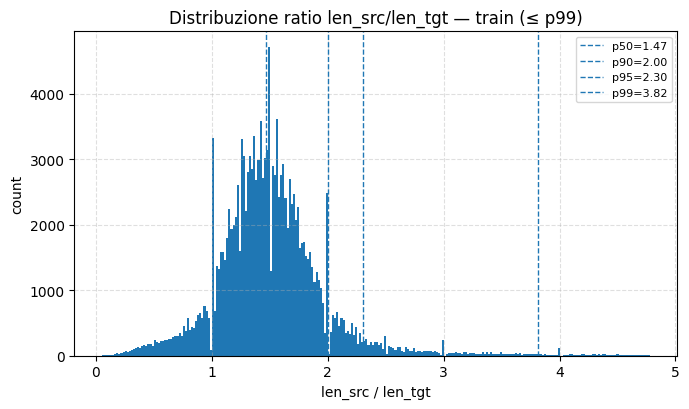


[validation] n=3000  —  keep-rate per intervalli fissi
  ratio 0.50–2.00: keep_rate = 0.945
  ratio 1/2.25-2.25: keep_rate = 0.981
  ratio 0.33–3.00: keep_rate = 0.999
  ratio 0.25–4.00: keep_rate = 0.999
  ratio 0.80–1.25: keep_rate = 0.215
  ratio 0.90–1.10: keep_rate = 0.055


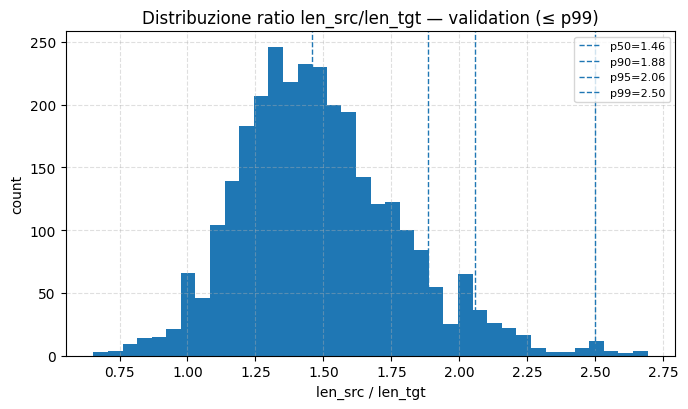


[test] n=3003  —  keep-rate per intervalli fissi
  ratio 0.50–2.00: keep_rate = 0.958
  ratio 1/2.25-2.25: keep_rate = 0.990
  ratio 0.33–3.00: keep_rate = 0.999
  ratio 0.25–4.00: keep_rate = 1.000
  ratio 0.80–1.25: keep_rate = 0.242
  ratio 0.90–1.10: keep_rate = 0.088


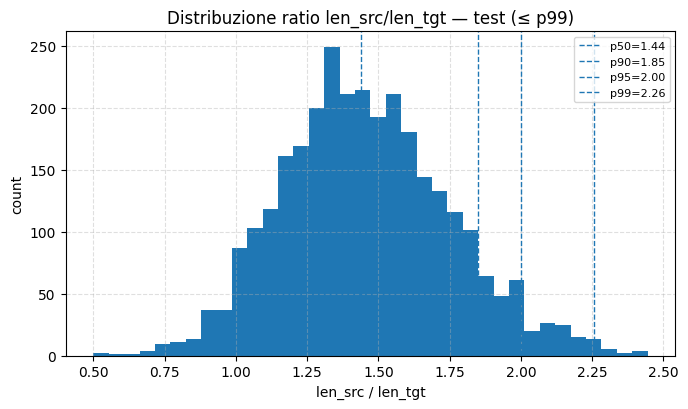

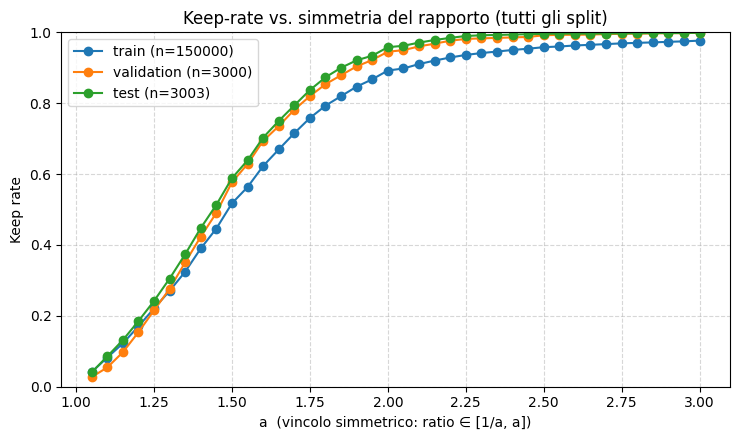

In [ ]:
# === Keep-rate su rapporto len_src/len_tgt (nessuna nuova colonna) ===
import numpy as np
import matplotlib.pyplot as plt

# --- Utility ---
def keep_rate_between(len_src, len_tgt, rmin, rmax):
    """Percentuale di esempi con ratio in [rmin, rmax]."""
    ls = np.asarray(len_src, dtype=np.float32)
    lt = np.asarray(len_tgt, dtype=np.float32)
    if ls.size == 0 or lt.size == 0:
        return 0.0
    ratio = ls / np.maximum(1.0, lt)
    mask = (ratio >= rmin) & (ratio <= rmax)
    return float(mask.mean()), ratio

def report_fixed_ranges(split_name, dset, ranges):
    ls = np.asarray(dset["len_src"], dtype=np.int32)
    lt = np.asarray(dset["len_tgt"], dtype=np.int32)
    print(f"\n[{split_name}] n={len(ls)}  —  keep-rate per intervalli fissi")
    out = []
    for label, rmin, rmax in ranges:
        kr, _ = keep_rate_between(ls, lt, rmin, rmax)
        out.append((label, kr))
        print(f"  ratio {label:<9}: keep_rate = {kr:.3f}")
    return out

def symmetric_curve(split_name, dset, a_min=1.05, a_max=3.00, step=0.05):
    """Curva keep-rate per vincolo simmetrico: ratio ∈ [1/a, a]."""
    ls = np.asarray(dset["len_src"], dtype=np.int32)
    lt = np.asarray(dset["len_tgt"], dtype=np.int32)
    a_vals = np.arange(a_min, a_max + 1e-9, step)
    keep = []
    for a in a_vals:
        kr, _ = keep_rate_between(ls, lt, 1.0/float(a), float(a))
        keep.append(kr)
    keep = np.asarray(keep, dtype=np.float32)
    return a_vals, keep

def plot_ratio_distribution(split_name, dset, qclip=0.995, bins="fd", min_bins=30):
    ls = np.asarray(dset["len_src"], dtype=np.int32)
    lt = np.asarray(dset["len_tgt"], dtype=np.int32)
    ratio = ls / np.maximum(1, lt)
    hi = np.quantile(ratio, qclip)
    ratio_clip = ratio[ratio <= hi]
    # bins adattivi
    edges = np.histogram_bin_edges(ratio_clip, bins=bins)
    if (len(edges) - 1) < min_bins:
        edges = np.linspace(ratio_clip.min(), ratio_clip.max(), min_bins + 1)
    plt.figure(figsize=(7,4.2))
    plt.hist(ratio_clip, bins=edges)
    for p in (50, 90, 95, 99):
        v = np.percentile(ratio, p)
        if v <= hi:
            plt.axvline(v, linestyle="--", linewidth=1, label=f"p{p}={v:.2f}")
    plt.title(f"Distribuzione ratio len_src/len_tgt — {split_name} (≤ p{int(qclip*100)})")
    plt.xlabel("len_src / len_tgt"); plt.ylabel("count")
    plt.legend(loc="upper right", fontsize=8)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

SPLITS = [s for s in ("train","validation","test") if s in ds_sampled]

FIXED_RANGES = [
    ("0.50–2.00", 0.50, 2.00),
    ("1/2.25-2.25", 1/2.25, 2.25),
    ("0.33–3.00", 0.33, 3.00),
    ("0.25–4.00", 0.25, 4.00),
    ("0.80–1.25", 0.80, 1.25),
    ("0.90–1.10", 0.90, 1.10),
]

all_curves = {}
for sp in SPLITS:
    d = ds_sampled[sp]
    # 1) Report fixed intervals
    _ = report_fixed_ranges(sp, d, FIXED_RANGES)

    # 2) Symmetric curve ratio ∈ [1/a, a]
    a_vals, keep_vals = symmetric_curve(sp, d, a_min=1.05, a_max=3.00, step=0.05)
    all_curves[sp] = (a_vals, keep_vals)

    # 3) Plot ratio distributions
    plot_ratio_distribution(sp, d, qclip=0.995)

# 4) Comparative plot between splits
plt.figure(figsize=(7.5,4.5))
for sp in SPLITS:
    a_vals, keep_vals = all_curves[sp]
    plt.plot(a_vals, keep_vals, marker="o", label=f"{sp} (n={len(ds_sampled[sp])})")
plt.xlabel("a  (vincolo simmetrico: ratio ∈ [1/a, a])")
plt.ylabel("Keep rate")
plt.title("Keep-rate vs. simmetria del rapporto (tutti gli split)")
plt.ylim(0.0, 1.0)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


# COMET Kiwi 22

In [ ]:
# === COMETKIWI-22 (reference-free) ===

!pip -q install "unbabel-comet>=2.2.4,<3.0.0" "huggingface_hub>=0.24.0"

import os, logging, warnings, shutil, tempfile, torch
from tqdm.auto import tqdm
from datasets import DatasetDict
from getpass import getpass
from huggingface_hub import login
from comet import download_model, load_from_checkpoint

# -------------------- Mute logging & speed knobs --------------------
warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

for name in [
    "pytorch_lightning",
    "pytorch_lightning.utilities.rank_zero",
    "pytorch_lightning.accelerators.cuda",
    "lightning.pytorch",
    "lightning.pytorch.utilities.rank_zero",
    "lightning.pytorch.accelerators.cuda",
]:
    logging.getLogger(name).setLevel(logging.ERROR)

logging.getLogger("pytorch_lightning").propagate = False
logging.getLogger("lightning.pytorch").propagate = False

if torch.cuda.is_available():
    try:
        torch.backends.cuda.matmul.allow_tf32 = True
        if hasattr(torch, "set_float32_matmul_precision"):
            torch.set_float32_matmul_precision("high")  # permette TF32 in PyTorch 2.x
    except Exception:
        pass

# -------------------- Config --------------------
MODEL_ID = "Unbabel/wmt22-cometkiwi-da"    # Kiwi-22 QE (gated, ref-free)
SRC_LANG = "de"
TGT_LANG = "en"
BATCH_SIZE = 256
USE_GPU   = torch.cuda.is_available()
OVERWRITE = False
COL_NAME  = "cometkiwi22"

# -------------------- Login HF (token richiesto via prompt) --------------------
print("To access gated repo token needed")
hf_token = getpass("HF token: ").strip()
if not hf_token:
    raise RuntimeError("Missing token, insert valid token")
login(token=hf_token, add_to_git_credential=False)
print("Login completed..")

# -------------------- Load Kiwi-22 --------------------
try:
    ckpt_path = download_model(MODEL_ID)
    model = load_from_checkpoint(ckpt_path)
except Exception as e:
    raise RuntimeError(
        f"Impossible to download {MODEL_ID}. "
        "Ensure repo access. "
        f"Details: {e}"
    )

device = "cuda" if USE_GPU else "cpu"
print(f"Model ready: {MODEL_ID}  |  device={device}")

# -------------------- Inference --------------------
def _extract_seg_scores(pred_out):
    if isinstance(pred_out, tuple) and len(pred_out) >= 1:
        seg_scores = pred_out[0]
    elif isinstance(pred_out, dict):
        for k in ("seg_scores", "scores", "segment_scores", "segments_scores"):
            if k in pred_out:
                seg_scores = pred_out[k]
                break
        else:
            raise ValueError(f"Output COMET not expected (chiavi={list(pred_out.keys())}).")
    elif hasattr(pred_out, "scores"):
        seg_scores = pred_out.scores
    else:
        raise ValueError(f"COMET output type unknown: {type(pred_out)}")
    return [float(x) for x in seg_scores]

def predict_scores(src_list, mt_list):
    data = [{"src": s or "", "mt": t or ""} for s, t in zip(src_list, mt_list)]
    pred_out = model.predict(
        data,
        batch_size=BATCH_SIZE,
        gpus=1 if USE_GPU else 0,
        progress_bar=False,
    )
    return _extract_seg_scores(pred_out)

def compute_split(dset_split, split_name):
    if (COL_NAME in dset_split.column_names) and not OVERWRITE:
        print(f"[{split_name}] {COL_NAME} Already present → skip (OVERWRITE=False)")
        return dset_split

    trans   = dset_split["translation"]
    src_all = [ex.get(SRC_LANG, "") for ex in trans]
    mt_all  = [ex.get(TGT_LANG, "") for ex in trans]
    n = len(src_all)
    print(f"[{split_name}] n={n} → computing {COL_NAME} (batch={BATCH_SIZE}, {device})")

    scores = []
    for i in tqdm(range(0, n, BATCH_SIZE), leave=False):
        j = min(i + BATCH_SIZE, n)
        scores.extend(predict_scores(src_all[i:j], mt_all[i:j]))

    assert len(scores) == n
    if COL_NAME in dset_split.column_names:
        dset_split = dset_split.remove_columns([COL_NAME])
    dset_split = dset_split.add_column(COL_NAME, scores)
    print(f"[{split_name}] Column added '{COL_NAME}'")
    return dset_split

# -------------------- On all splits --------------------
SPLITS = [s for s in ("train","validation","test") if s in ds_sampled]
updated = {}
for sp in SPLITS:
    updated[sp] = compute_split(ds_sampled[sp], sp)
ds_sampled = DatasetDict(updated)

# -------------------- Saving on Drive --------------------
from google.colab import drive
drive.mount("/content/drive", force_remount=False)
BASE_DIR  = "/content/drive/MyDrive/mt_datasets"
DATA_NAME = f"wmt14_de-en_sample{len(ds_sampled['train'])}_qwen_columns"
SAVE_DIR  = os.path.join(BASE_DIR, DATA_NAME)
os.makedirs(BASE_DIR, exist_ok=True)

tmp_dir = tempfile.mkdtemp(prefix="ds_tmp_")
ds_sampled.save_to_disk(tmp_dir)
if os.path.isdir(SAVE_DIR):
    shutil.rmtree(SAVE_DIR)
shutil.move(tmp_dir, SAVE_DIR)

print(f"Dataset saved with column '{COL_NAME}' in:\n  {SAVE_DIR}")
print("Direction evaluated:", f"{SRC_LANG} → {TGT_LANG}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.7/529.7 kB 42.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

LICENSE:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

checkpoints/model.ckpt:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

hparams.yaml:   0%|          | 0.00/716 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/513 [00:00<?, ?B/s]

✅ Modello pronto: Unbabel/wmt22-cometkiwi-da  |  device=cuda
[train] n=150000 → calcolo cometkiwi22 (batch=256, cuda)


  0%|          | 0/586 [00:00<?, ?it/s]

[train] ✅ aggiunta colonna 'cometkiwi22'
[validation] n=3000 → calcolo cometkiwi22 (batch=256, cuda)


  0%|          | 0/12 [00:00<?, ?it/s]

[validation] ✅ aggiunta colonna 'cometkiwi22'
[test] n=3003 → calcolo cometkiwi22 (batch=256, cuda)


  0%|          | 0/12 [00:00<?, ?it/s]

[test] ✅ aggiunta colonna 'cometkiwi22'
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving the dataset (0/1 shards):   0%|          | 0/150000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3003 [00:00<?, ? examples/s]

💾 Dataset salvato con colonna 'cometkiwi22' in:
  /content/drive/MyDrive/mt_datasets/wmt14_de-en_sample150000_qwen_columns
ℹ️ Direzione valutata: de → en


# Loading filtered dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
import os
from datasets import load_from_disk

# === Config ===
DATA_NAME = "wmt14_de-en_sample150000_qwen_columns"

BASE_DIR = "/content/drive/MyDrive/mt_datasets"
SAVE_DIR = os.path.join(BASE_DIR, DATA_NAME)

if not os.path.isdir(SAVE_DIR):
    raise FileNotFoundError(f"Cartella non trovata: {SAVE_DIR}")

print(f"Loading dataset from: {SAVE_DIR}")
ds_sampled = load_from_disk(SAVE_DIR)

print({split: len(ds_sampled[split]) for split in ds_sampled.keys()})
ds_sampled

Mounted at /content/drive
Loading dataset from: /content/drive/MyDrive/mt_datasets/wmt14_de-en_sample150000_qwen_columns
{'train': 150000, 'validation': 3000, 'test': 3003}


DatasetDict({
    train: Dataset({
        features: ['translation', 'len_src', 'len_tgt', 'len_sum', 'LID_src', 'LID_tgt', 'cometkiwi22'],
        num_rows: 150000
    })
    validation: Dataset({
        features: ['translation', 'len_src', 'len_tgt', 'len_sum', 'LID_src', 'LID_tgt', 'cometkiwi22'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['translation', 'len_src', 'len_tgt', 'len_sum', 'LID_src', 'LID_tgt', 'cometkiwi22'],
        num_rows: 3003
    })
})

[train] cometkiwi22 — n=150000
  Low percentiles: p5=0.3527, p10=0.4381, p20=0.6398, p30=0.7393, p40=0.7824
  Percentile@0.6: 17.64% (≈ p17.64)
[validation] cometkiwi22 — n=3000
  Low percentiles: p5=0.6758, p10=0.7287, p20=0.7717, p30=0.7934, p40=0.8104
  Percentile@0.6: 1.63% (≈ p1.63)
[test] cometkiwi22 — n=3003
  Low percentiles: p5=0.6949, p10=0.7394, p20=0.7816, p30=0.8026, p40=0.8161
  Percentile@0.6: 1.63% (≈ p1.63)


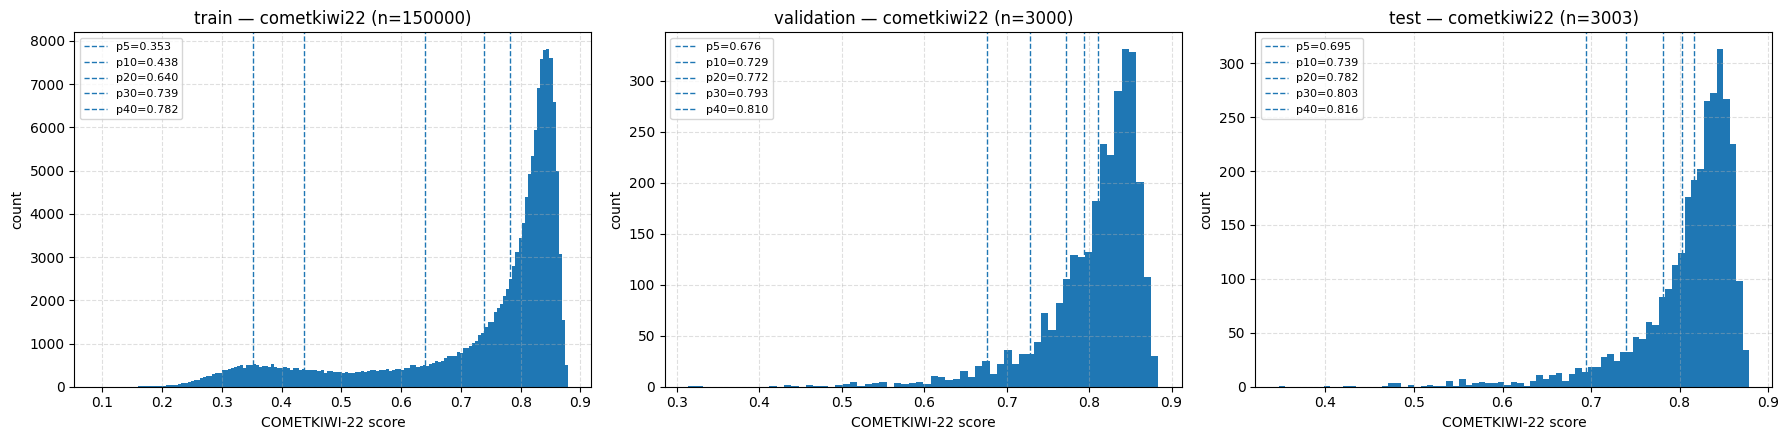

In [ ]:
# === Plot Histograms with COMET score ===
import numpy as np
import matplotlib.pyplot as plt

COL_NAME = "cometkiwi22"
SPLITS   = [s for s in ("train","validation","test") if s in ds_sampled]
LOW_PS   = (5, 10, 20, 30, 40)   # percentiles to show
VALUE_Q  = 0.6
QCLIP    = 0.999
MIN_BINS = 30

def stats_low(arr):
    arr = np.asarray(arr, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return {f"p{p}": np.nan for p in LOW_PS}
    return {f"p{p}": float(np.percentile(arr, p)) for p in LOW_PS}

def percentile_of_value(arr_sorted, v):
    if arr_sorted.size == 0:
        return np.nan
    return float(np.searchsorted(arr_sorted, v, side="right") / arr_sorted.size * 100.0)

def hist_with_low_percentiles(ax, vals, title, qclip=QCLIP, min_bins=MIN_BINS):
    vals = np.asarray(vals, dtype=float)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        ax.set_title(f"{title} (vuoto)")
        ax.axis("off")
        return
    hi = np.quantile(vals, qclip)
    vals_clip = vals[vals <= hi]
    edges = np.histogram_bin_edges(vals_clip, bins="fd")
    if (len(edges) - 1) < min_bins:
        edges = np.linspace(vals_clip.min(), vals_clip.max(), min_bins + 1)
    ax.hist(vals_clip, bins=edges)
    for p in LOW_PS:
        v = np.percentile(vals, p)
        if v <= hi:
            ax.axvline(v, linestyle="--", linewidth=1, label=f"p{p}={v:.3f}")
    ax.set_title(title)
    ax.set_xlabel("COMETKIWI-22 score")
    ax.set_ylabel("count")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(loc="upper left", fontsize=8)

cols = len(SPLITS)
plt.figure(figsize=(6 * max(cols, 1), 4.5))
for j, sp in enumerate(SPLITS, start=1):
    d = ds_sampled[sp]
    if COL_NAME not in d.column_names:
        raise ValueError(f"Lo split '{sp}' non ha la colonna '{COL_NAME}'.")
    vals = np.asarray(d[COL_NAME], dtype=float)
    vals = vals[np.isfinite(vals)]
    n = vals.size

    lows = stats_low(vals)
    lows_pretty = ", ".join([f"{k}={lows[k]:.4f}" for k in [f"p{p}" for p in LOW_PS]])
    print(f"[{sp}] {COL_NAME} — n={n}")
    print("  Low percentiles:", lows_pretty)

    vals_sorted = np.sort(vals)
    p_of_07 = percentile_of_value(vals_sorted, VALUE_Q)
    if np.isnan(p_of_07):
        print("  Percentile@0.6: n/d (split vuoto)")
    else:
        print(f"  Percentile@{VALUE_Q:.1f}: {p_of_07:.2f}% (≈ p{p_of_07:.2f})")

    # plot
    ax = plt.subplot(1, cols, j)
    hist_with_low_percentiles(ax, vals, f"{sp} — {COL_NAME} (n={n})")

plt.tight_layout()
plt.show()


# Filter simulation

In [ ]:
# === Filtering simulation to set thresholds ===
MAX_LEN_SUM = 169
LID_MIN     = 0.95
RATIO_MIN   = 1/2.25
RATIO_MAX   = 2.25
COMET_MIN   = 0.60

required_cols = {
    "len_src": "Esegui prima la cella che calcola le lunghezze token.",
    "len_tgt": "Esegui prima la cella che calcola le lunghezze token.",
}
if COMET_MIN is not None:
    required_cols["cometkiwi22"] = "Manca la colonna 'cometkiwi22'. Esegui prima la cella COMETKIWI-22."
if LID_MIN is not None:
    required_cols["LID_src"] = "Manca 'LID_src'. Esegui prima la cella fastText LID."
    required_cols["LID_tgt"] = "Manca 'LID_tgt'. Esegui prima la cella fastText LID."

SPLITS = [s for s in ("train","validation","test") if s in ds_sampled]

def check_columns(dset_split):
    missing = [c for c in required_cols if c not in dset_split.column_names]
    if missing:
        msgs = [f"- {c}: {required_cols[c]}" for c in missing]
        raise ValueError("Colonne richieste mancanti:\n" + "\n".join(msgs))

def keep_rate_for_split(dset_split):
    import numpy as np
    check_columns(dset_split)

    len_src = np.asarray(dset_split["len_src"], dtype=np.int32)
    len_tgt = np.asarray(dset_split["len_tgt"], dtype=np.int32)
    len_sum = len_src + len_tgt

    mask = np.ones(len(len_src), dtype=bool)

    if MAX_LEN_SUM is not None:
        mask &= (len_sum <= int(MAX_LEN_SUM))

    if (RATIO_MIN is not None) or (RATIO_MAX is not None):
        denom = np.maximum(1, len_tgt)
        ratio = len_src / denom
        if RATIO_MIN is not None:
            mask &= (ratio >= float(RATIO_MIN))
        if RATIO_MAX is not None:
            mask &= (ratio <= float(RATIO_MAX))

    if LID_MIN is not None:
        import numpy as np
        lid_s = np.asarray(dset_split["LID_src"], dtype=np.float32)
        lid_t = np.asarray(dset_split["LID_tgt"], dtype=np.float32)
        mask &= (lid_s >= float(LID_MIN)) & (lid_t >= float(LID_MIN))

    if COMET_MIN is not None:
        import numpy as np
        comet = np.asarray(dset_split["cometkiwi22"], dtype=np.float32)
        mask &= (comet >= float(COMET_MIN))

    kept = int(mask.sum())
    total = int(mask.size)
    keep_rate = (kept / total) if total > 0 else 0.0
    return keep_rate, kept, total

# --- Report ---
print("== Soglie attive ==")
print(f"- MAX_LEN_SUM: {MAX_LEN_SUM}")
print(f"- LID_MIN    : {LID_MIN}")
print(f"- RATIO_MIN  : {RATIO_MIN}")
print(f"- RATIO_MAX  : {RATIO_MAX}")
print(f"- COMET_MIN  : {COMET_MIN}")
print("\n== Keep-rate simulato ==")

for sp in SPLITS:
    kr, kept, total = keep_rate_for_split(ds_sampled[sp])
    print(f"[{sp:10s}] keep = {kr*100:6.2f}%   ({kept}/{total})")


== Soglie attive ==
- MAX_LEN_SUM: 169
- LID_MIN    : 0.95
- RATIO_MIN  : 0.4444444444444444
- RATIO_MAX  : 2.25
- COMET_MIN  : 0.6

== Keep-rate simulato ==
[train     ] keep =  74.64%   (111966/150000)
[validation] keep =  92.67%   (2780/3000)
[test      ] keep =  94.91%   (2850/3003)


# Filtering

In [ ]:
# === Filters TRAIN & VALIDATION (non TEST) ===
import os, shutil, tempfile, numpy as np
from datasets import DatasetDict

# ---------- Thresholds ----------
MAX_LEN_SUM = 169
LID_MIN     = 0.95
RATIO_MIN   = 1/2.25
RATIO_MAX   = 2.25
COMET_MIN   = 0.60

# ---------- Helper ----------
def _need_cols(use_comet: bool):
    cols = ["len_src", "len_tgt"]
    if LID_MIN is not None:
        cols += ["LID_src", "LID_tgt"]
    if use_comet and (COMET_MIN is not None):
        cols += ["cometkiwi22"]
    return cols

def _mask_numpy(dset, *, use_comet=True):
    """Create boolean mask"""
    need = _need_cols(use_comet)
    missing = [c for c in need if c not in dset.column_names]
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    len_src = np.asarray(dset["len_src"], dtype=np.int32)
    len_tgt = np.asarray(dset["len_tgt"], dtype=np.int32)
    mask = np.ones(len(len_src), dtype=bool)

    if MAX_LEN_SUM is not None:
        mask &= (len_src + len_tgt) <= int(MAX_LEN_SUM)

    if (RATIO_MIN is not None) or (RATIO_MAX is not None):
        ratio = len_src / np.maximum(1, len_tgt)
        if RATIO_MIN is not None:
            mask &= (ratio >= float(RATIO_MIN))
        if RATIO_MAX is not None:
            mask &= (ratio <= float(RATIO_MAX))

    if LID_MIN is not None:
        lid_s = np.asarray(dset["LID_src"], dtype=np.float32)
        lid_t = np.asarray(dset["LID_tgt"], dtype=np.float32)
        mask &= (lid_s >= float(LID_MIN)) & (lid_t >= float(LID_MIN))

    if use_comet and (COMET_MIN is not None):
        comet = np.asarray(dset["cometkiwi22"], dtype=np.float32)
        mask &= (comet >= float(COMET_MIN))

    return mask

def _filter_with_select(dset, split_name, *, use_comet=True):
    mask = _mask_numpy(dset, use_comet=use_comet)
    idx = np.nonzero(mask)[0].tolist()
    d2 = dset.select(idx)
    print(f"[{split_name}] kept {len(d2)}/{len(dset)} = {100.0*len(d2)/len(dset):.2f}%")
    return d2

# ---------- Apply filters ----------
splits = [s for s in ("train","validation","test") if s in ds_sampled]
updated = {}
for sp in splits:
    if sp in ("train", "validation"):
        updated[sp] = _filter_with_select(ds_sampled[sp], sp, use_comet=True)
    else:
        updated[sp] = ds_sampled[sp]
        print(f"[{sp}] Not filtered.")

ds_filtered = DatasetDict(updated)

# ---------- Save on drive ----------
from google.colab import drive
drive.mount("/content/drive", force_remount=False)

BASE_DIR  = "/content/drive/MyDrive/mt_datasets"
base_name = f"wmt14_de-en_sample{len(ds_sampled['train'])}"
tag = f"len{MAX_LEN_SUM}_lid{int(LID_MIN*100) if LID_MIN is not None else 'NA'}" \
      f"_r{RATIO_MAX}_ck{int(COMET_MIN*100) if COMET_MIN is not None else 'NA'}" \
      f"_trainVAL_filtered_testRAW"
SAVE_DIR = os.path.join(BASE_DIR, f"{base_name}__filtered__{tag}")

os.makedirs(BASE_DIR, exist_ok=True)
tmp_dir = tempfile.mkdtemp(prefix="ds_tmp_filt_")
ds_filtered.save_to_disk(tmp_dir)
if os.path.isdir(SAVE_DIR):
    shutil.rmtree(SAVE_DIR)
shutil.move(tmp_dir, SAVE_DIR)

print("\n Saved:")
for sp in ds_filtered.keys():
    print(f"  {sp:10s}: {len(ds_filtered[sp])} rows")
print("→", SAVE_DIR)


[train] kept 111966/150000 = 74.64%
[validation] kept 2780/3000 = 92.67%
[test] non filtrato (copiato così com'è).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving the dataset (0/1 shards):   0%|          | 0/111966 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2780 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3003 [00:00<?, ? examples/s]


✅ Salvataggio completato:
  train     : 111966 righe
  validation: 2780 righe
  test      : 3003 righe
→ /content/drive/MyDrive/mt_datasets/wmt14_de-en_sample150000__filtered__len169_lid95_r0.4444444444444444-2.25_ck60_trainVAL_filtered_testRAW
